# UTS PSD

## Preparation

### Load Library

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import BaggingRegressor

### Load Data

In [117]:
df = pd.read_csv('https://raw.githubusercontent.com/Rieko00/psd/main/bmri_uni.csv')
df

,Tanggal,Pembukaan
0,11/10/2024,7025
1,10/10/2024,6925
2,09/10/2024,7075
3,08/10/2024,6825
4,07/10/2024,6925
...,...,...
1398,08/01/2019,7425
1399,07/01/2019,7500
1400,04/01/2019,7175
1401,03/01/2019,7275


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tanggal    1403 non-null   object
 1   Pembukaan  1403 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.1+ KB


### Change Dtypes

In [119]:
df = df[['Tanggal', 'Pembukaan']]
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, format='%d/%m/%Y').dt.date
df.set_index('Tanggal', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

### Plot Data

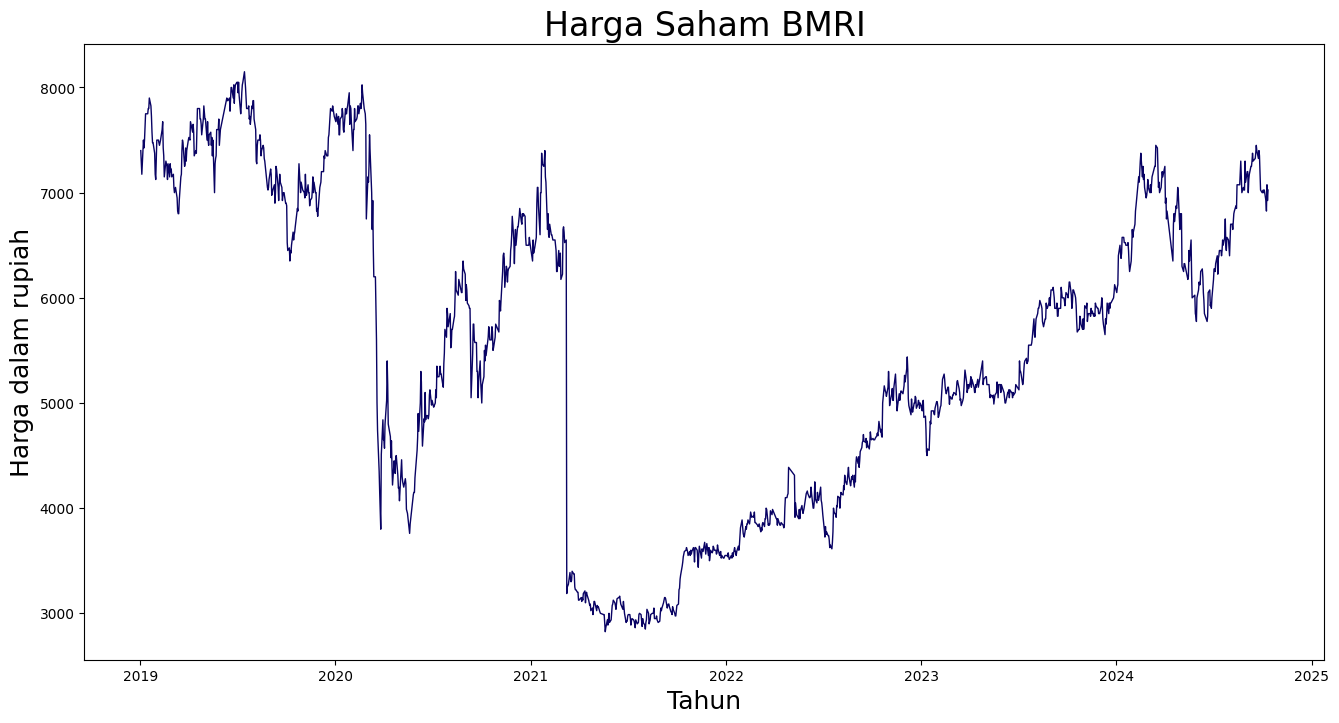

In [120]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Tanggal', y='Pembukaan', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

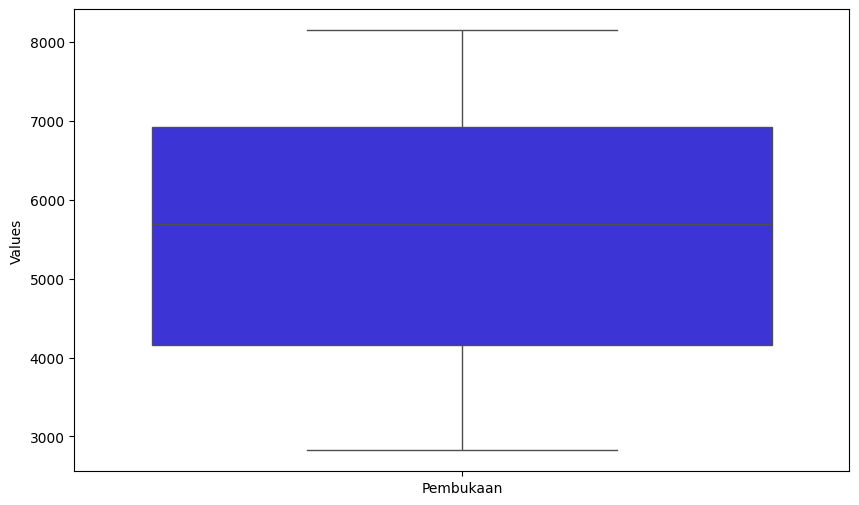

In [121]:
features = ['Pembukaan']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.ylabel('Values')
plt.show()

## Prepocessing

### Data Normalization

In [122]:
scaler = MinMaxScaler()
df['Pembukaan'] = scaler.fit_transform(df[['Pembukaan']])

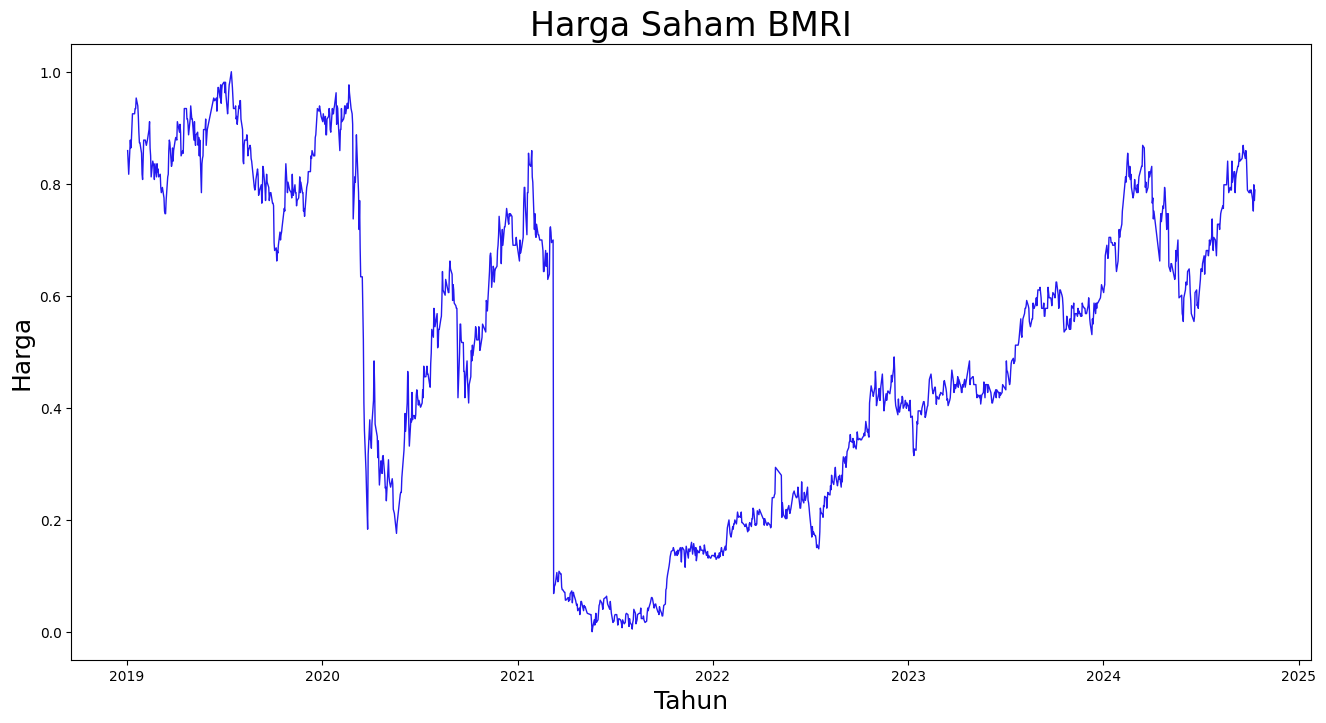

In [123]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(x='Tanggal', y='Pembukaan', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

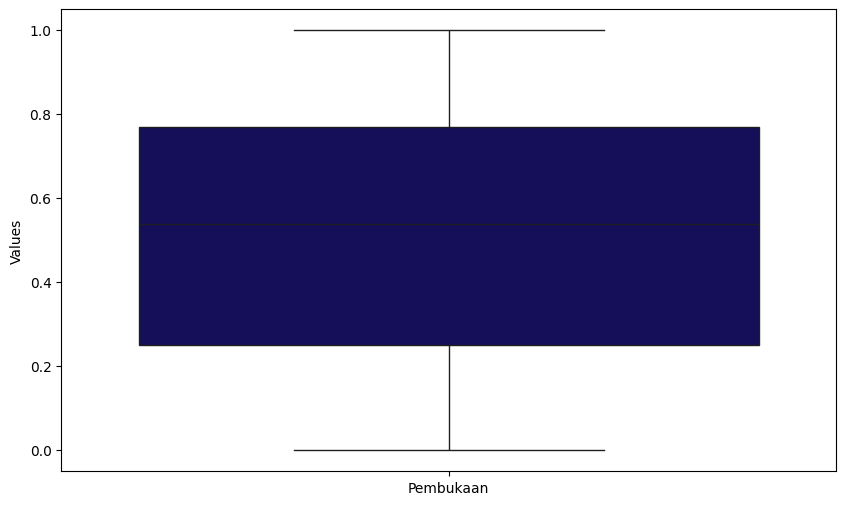

In [124]:
features = ['Pembukaan']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.ylabel('Values')
plt.show()

In [125]:
df.head()

,Pembukaan
Tanggal,
2019-01-02,0.859155
2019-01-03,0.835681
2019-01-04,0.816901
2019-01-07,0.877934
2019-01-08,0.863850


### Sliding Window

In [126]:
def sliding_window(data, lag):
    series = data['Pembukaan']
    result = pd.DataFrame()
    for l in lag:
        result[f'open-{l}'] = series.shift(l)

    result['open'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]
    return result

windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3']]
print(windowed_data)

                open    open-1    open-2    open-3
Tanggal                                           
2019-01-07  0.877934  0.816901  0.835681  0.859155
2019-01-08  0.863850  0.877934  0.816901  0.835681
2019-01-09  0.877934  0.863850  0.877934  0.816901
2019-01-10  0.901408  0.877934  0.863850  0.877934
2019-01-11  0.924883  0.901408  0.877934  0.863850
...              ...       ...       ...       ...
2024-10-07  0.769953  0.788732  0.784038  0.788732
2024-10-08  0.751174  0.769953  0.788732  0.784038
2024-10-09  0.798122  0.751174  0.769953  0.788732
2024-10-10  0.769953  0.798122  0.751174  0.769953
2024-10-11  0.788732  0.769953  0.798122  0.751174

[1400 rows x 4 columns]


### Split Data

In [127]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[['open-1', 'open-2', 'open-3']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1120, 3)
y_train shape: (1120, 1)
X_test shape: (280, 3)
y_test shape: (280, 1)


## Modelling

Pengukuran Akurasi

$MSE = mean((predicted - actual)^2)$

$RMSE = sqrt(mean((predicted - actual)^2))$

$MAPE = 100 * mean(abs((predicted - actual) / actual))$

### Bagging Linear Regression 



In [128]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.00045230041247564266
Root Mean Squared Error (RMSE): 0.021267355559063818
Mean Absolute Percentage Error (MAPE): 2.341169293979738 %


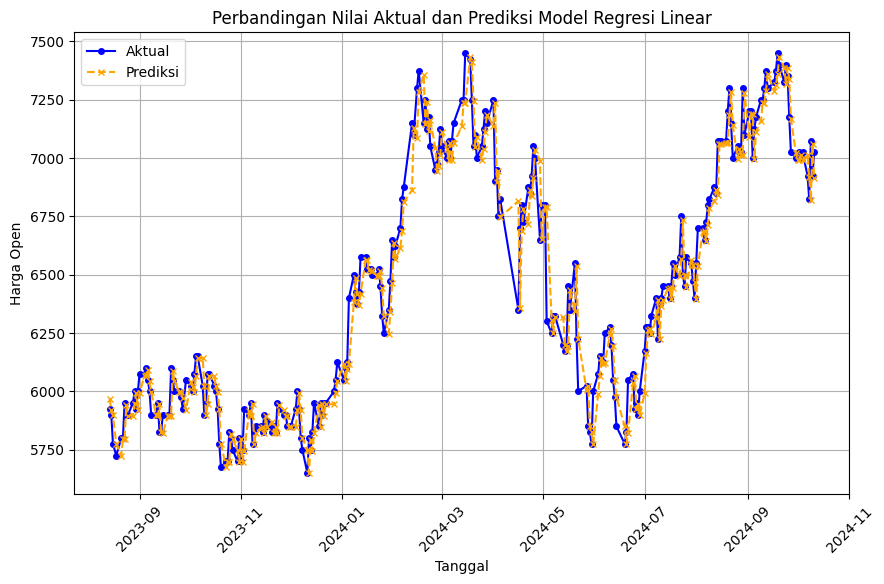

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [130]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = linear_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6916.001383650782 (-1.55%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [131]:
base_model = LinearRegression()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=10, bootstrap=True)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.0004520456888099398
Root Mean Squared Error: 0.021261366108741457
Mean Absolute Percentage Error (MAPE): 2.3418204049836984 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


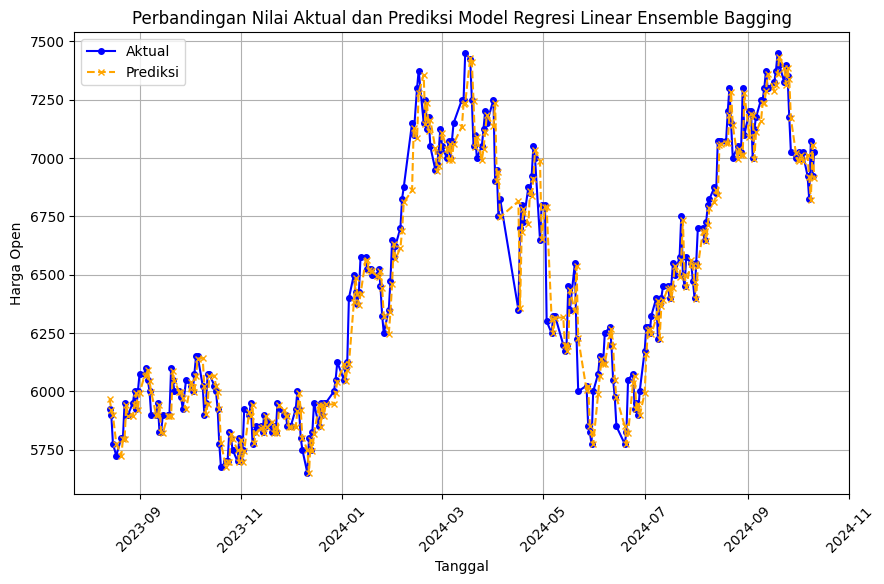

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [133]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100
if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6916.400225974266 (-1.55%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


### Bagging SVM

In [134]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

svm_model = SVR()
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.0010771866578538102
Root Mean Squared Error (RMSE): 0.032820521900996796
Mean Absolute Percentage Error (MAPE): 4.212439435355245 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


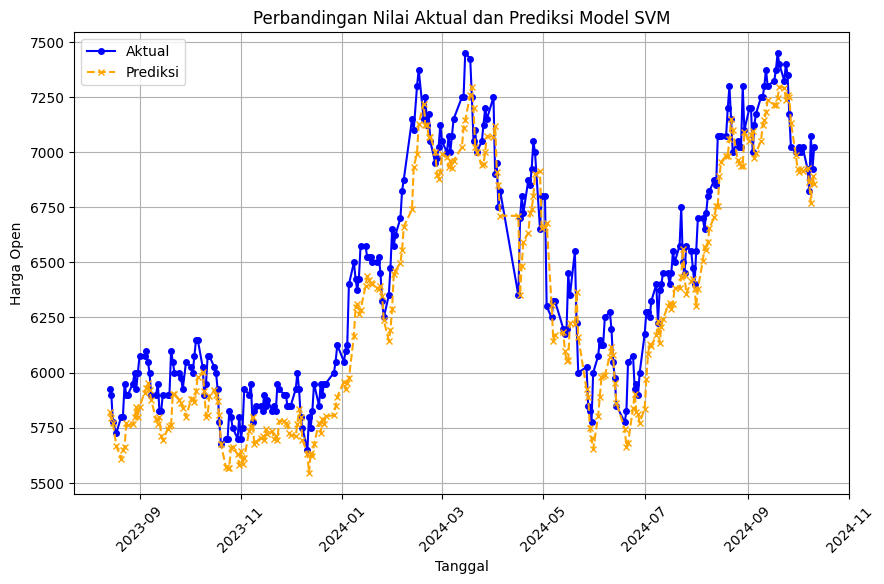

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model SVM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [136]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = svm_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6856.750398555171 (-2.40%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [137]:
base_model = SVR()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=50, bootstrap=True, random_state=42)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Mean Squared Error: 0.001350347565019255
Root Mean Squared Error: 0.03674707559819223
Mean Absolute Percentage Error (MAPE): 4.826791117208925 %


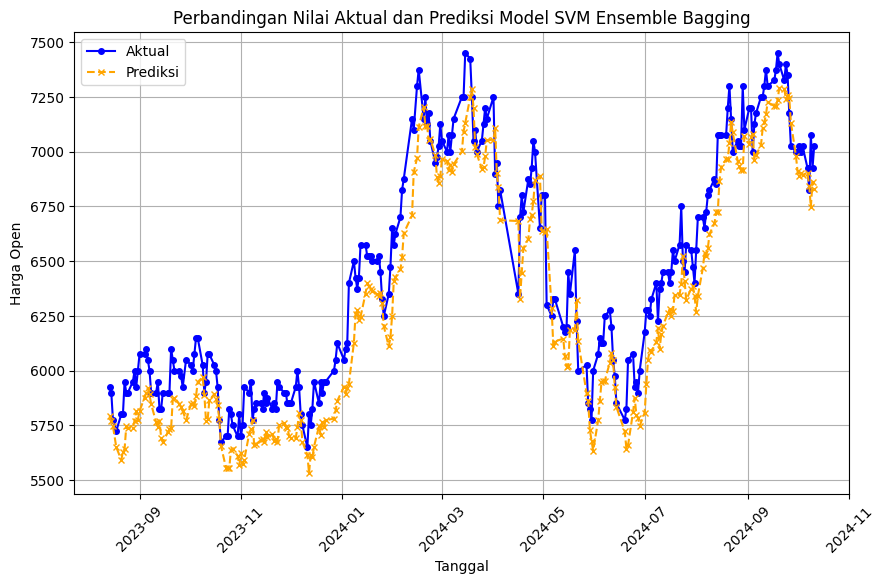

In [138]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model SVM Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [139]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6830.980449593076 (-2.76%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


### Bagging Tree

In [140]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train)

y_pred = tree_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.0012988730505096302
Root Mean Squared Error (RMSE): 0.036039881388673166
Mean Absolute Percentage Error (MAPE): 4.132636579071533 %


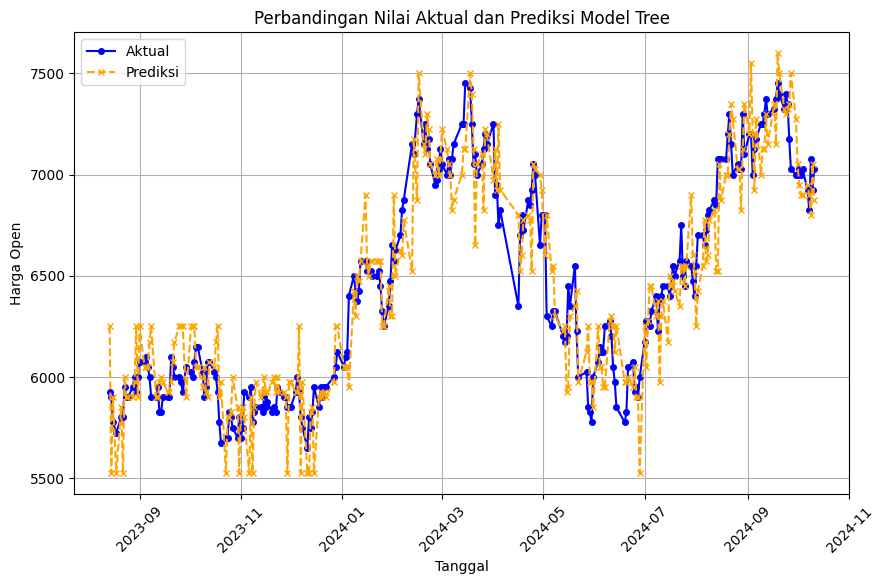

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Tree')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [142]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = tree_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6875.0 (-2.14%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [143]:
base_model = DecisionTreeRegressor()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=100, bootstrap=True, random_state=42)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Mean Squared Error: 0.0006663130072579486
Root Mean Squared Error: 0.025813039481199198
Mean Absolute Percentage Error (MAPE): 2.904578194079493 %


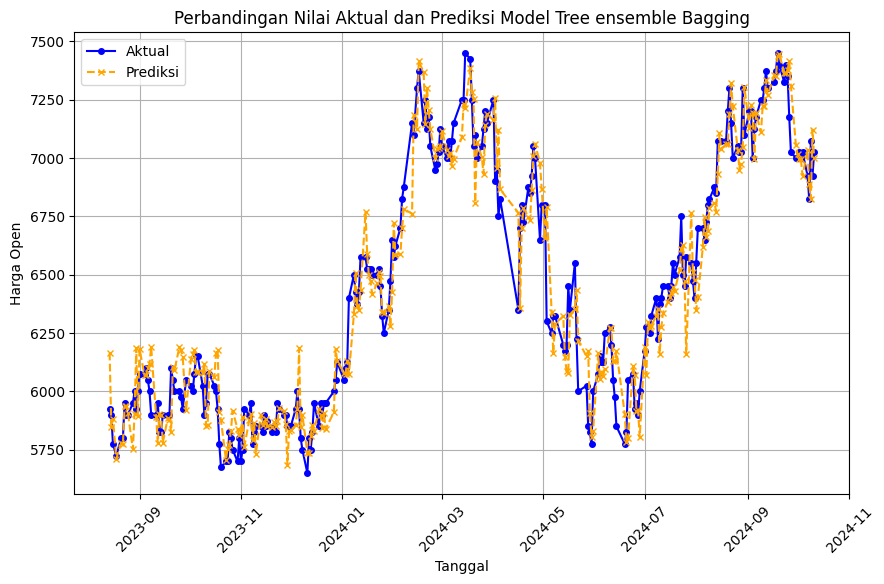

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Tree ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [145]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6999.749999999999 (-0.36%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


## Evaluasi

### Grid Search

In [147]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(input_df, target_df, splits, lags, estimators, bootstraps, max_samples):
    best_rmse = float('inf')
    best_params = None
    graph = pd.DataFrame()
    i = 0
    for lag_value in lags:
        lag = [i for i in range(1, lag_value+1)]  
        windowed_data = sliding_window(df, lag)
        windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
        input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
        target_df = windowed_data[['open']]
        for split in splits:
            x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
            for estimator in estimators:
                for bootstrap in bootstraps:
                    for max_sample in max_samples:
                        base_model = LinearRegression()
                        bagging_model = BaggingRegressor(estimator=base_model, n_estimators=estimator, bootstrap=bootstrap, max_samples=max_sample)
                        bagging_model.fit(x_train, y_train.values.ravel())
                        y_pred = bagging_model.predict(x_test)
                        i+=1
                        current_rmse = rmse(y_test, y_pred)
                        if current_rmse < best_rmse:
                            best_rmse = current_rmse
                            best_model = bagging_model
                            best_params = {'estimator': estimator, 'bootstrap': bootstrap, 'train_sample': split, 'max_sample': max_sample, 'lag': lag}
    return best_params, best_rmse, best_model, y_test, y_pred

lag = [3, 4, 5]
splits = [0.7, 0.75, 0.8, 0.85, 0.9]
estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

best_params, best_rmse, best_model = grid_search(input_df, target_df, splits, lag , estimators, bootstraps, max_samples)



In [148]:
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Model: {best_model}')

Best parameters: {'estimator': 20, 'bootstrap': True, 'train_sample': 0.7, 'max_sample': 0.8, 'lag': [1, 2, 3]}
Best RMSE: 0.019303724899504306
Best Model: BaggingRegressor(estimator=LinearRegression(), max_samples=0.8, n_estimators=20)


In [159]:
for lag_value in best_params['lag']:
    lag = [i for i in range(1, lag_value+1)]  
    windowed_data = sliding_window(df, lag)
    windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
    input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
    target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, best_params['train_sample'])

bagging_model = best_model
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.00037571016747297756
Root Mean Squared Error: 0.01938324450325532
Mean Absolute Percentage Error (MAPE): 2.4159652722920812 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


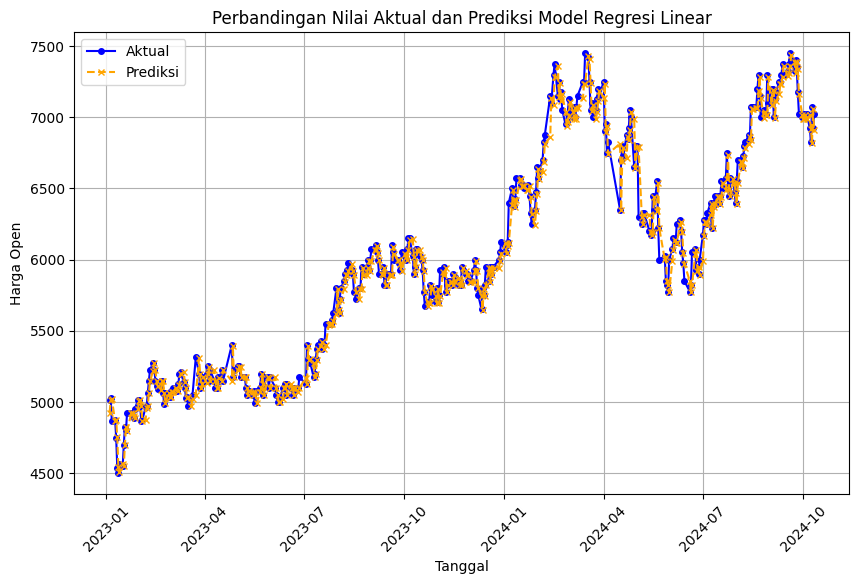

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Testing Model

In [161]:
# open_1 = int(input("Harga BMRI hari ini: "))
# open_2 = int(input("Harga BMRI 1 hari sebelumnya: "))
# open_3 = int(input("Harga BMRI 2 hari sebelumnya: "))

open_1 = 7025
open_2 = 7075
open_3 = 7000

last_row = np.array([
    scaler.transform([[open_1]]).flatten()[0],
    scaler.transform([[open_2]]).flatten()[0],
    scaler.transform([[open_3]]).flatten()[0]
]).reshape(1, -1)
last_row_df = pd.DataFrame(last_row, columns=['open-1', 'open-2', 'open-3'])
predicted_value_normalized = best_model.predict(last_row_df)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = open_1
percentage_change = ((predicted_value[0][0] - last_price) / last_price) * 100
change_sign = '+' if percentage_change > 0 else ''

formatted_predicted_value = f"{predicted_value[0][0]:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
formatted_last_price = f"{last_price:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

print(f'Harga BMRI Hari ini: Rp {formatted_last_price}')
print(f'Prediksi harga BMRI Besok: Rp {formatted_predicted_value} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: Rp 7.025,00
Prediksi harga BMRI Besok: Rp 7.012,93 (-0.17%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
